In [1]:
import numpy as np
import pytplot as tp
import pyspedas as sp
import astropy.units as u
import astropy.constants.si as c

from spacepy import pycdf
from astropy.convolution import Gaussian2DKernel, convolve
from scipy.optimize import curve_fit
from scipy.special import gamma
from tvolib import mpl_utils as mu

from wimh.utils.directory import resources_dir

Load PSP FLD and SPE data

In [2]:
trange = np.array(["2018-11-04T17:05", "2018-11-04T17:07:30"], dtype="datetime64[ns]")

sp.psp.fields(trange=trange.astype(str), level="l2", datatype="mag_rtn", time_clip=True)
t_fld, B_fld, _ = tp.get("psp_fld_l2_mag_RTN", dt=True, units=True)

data = pycdf.CDF(str(resources_dir / "psp_swp_spe_sf0_l3_pad_20181104_v03.cdf"))
t_spe = data["Epoch"][...].astype("datetime64[ns]")
idx = np.where((trange[0] <= t_spe) & (t_spe <= trange[1]))
F_spe = data["EFLUX_VS_PA_E"][...] * u.Unit("cm-2 s-1 sr-1")
W_spe = data["ENERGY_VALS"][...] * u.eV
P_spe = data["PITCHANGLE"][...] * u.deg
t_spe = t_spe[idx]
F_spe = F_spe[idx, ...].squeeze()
W_spe = W_spe[idx, ...].squeeze()
P_spe = P_spe[idx, ...].squeeze()
iw_pad = np.argmin(np.abs(W_spe - (E_pad := 300 * u.eV)), axis=1)
F_pad = np.take_along_axis(F_spe, iw_pad[:, np.newaxis, np.newaxis], axis=2).squeeze()
F_omni = np.nanmean(F_spe, axis=1)

15-Aug-23 18:44:35: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
15-Aug-23 18:44:35: File is current: /home/tvo/.local/share/spedas/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018110412_v02.cdf
15-Aug-23 18:44:55: Time clip was applied to: psp_fld_l2_mag_RTN
15-Aug-23 18:44:55: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
15-Aug-23 18:44:55: File is current: /home/tvo/.local/share/spedas/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018110412_v02.cdf
15-Aug-23 18:44:55: Time clip was applied to: psp_fld_l2_quality_flags


Plot overview

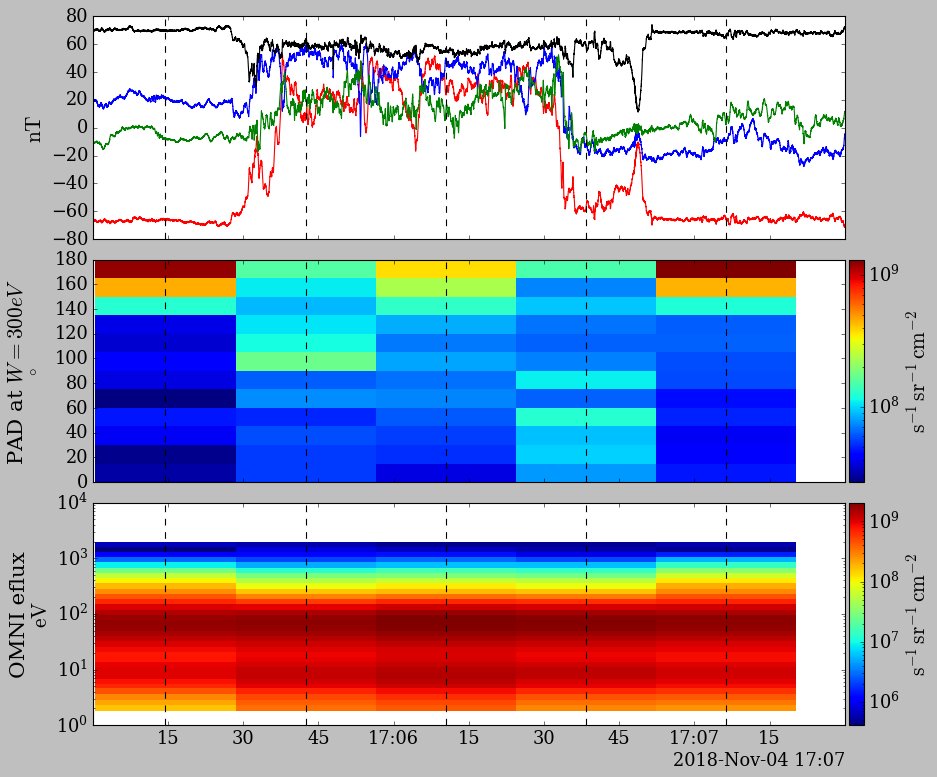

In [3]:
fig, axes = mu.plt.subplots(3, 1, sharex=True, figsize=(12, 10))

mu.add_colorbar(ax := axes[0]).remove()
ax.plot(t_fld, B_fld[:, 0], "-r")
ax.plot(t_fld, B_fld[:, 1], "-b")
ax.plot(t_fld, B_fld[:, 2], "-g")
ax.plot(t_fld, np.linalg.norm(B_fld, axis=1), "-k")
ax.set_ylabel(f"{B_fld.unit:latex_inline}")

cax = mu.add_colorbar(ax := axes[1])
tg_spe = (t_spe.astype("f8")[:, np.newaxis] * np.ones(P_spe.shape)).astype("datetime64[ns]")
im = ax.pcolormesh(tg_spe, P_spe.value, F_pad.value, cmap="jet", norm=mu.mplc.LogNorm())
cb = fig.colorbar(im, cax=cax)
cb.set_label(f"{F_pad.unit:latex_inline}")
ax.set_ylim(0, 180)
ax.set_ylabel(f"PAD at $W={E_pad.astype('i8')}$\n{P_spe.unit:latex_inline}")

cax = mu.add_colorbar(ax := axes[2])
tg_spe = (t_spe.astype("f8")[:, np.newaxis] * np.ones(W_spe.shape)).astype("datetime64[ns]")
im = ax.pcolormesh(tg_spe, W_spe.value, F_omni.value, cmap="jet", norm=mu.mplc.LogNorm())
cb = fig.colorbar(im, cax=cax)
cb.set_label(f"{F_omni.unit:latex_inline}")
ax.set_yscale("log")
ax.set_ylabel(f"OMNI eflux\n{W_spe.unit:latex_inline}")

for (i, ax) in enumerate(axes):
    ax.set_xlim(t_fld[0], t_fld[-1])
    for t in t_spe:
        ax.axvline(t, c="k", ls="--")

fig.tight_layout(h_pad=0.05)
mu.plt.show()

## Eflux plot

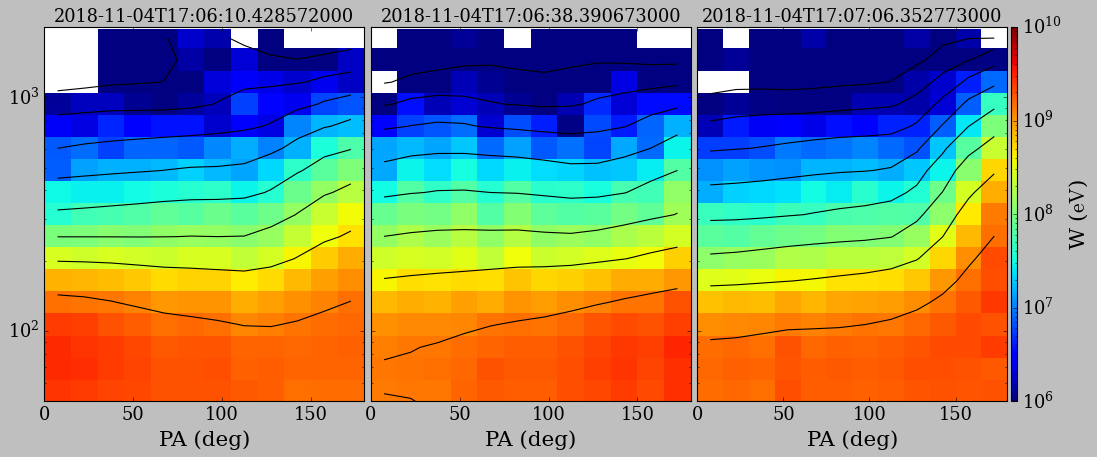

In [4]:
kernel = Gaussian2DKernel(1)
i1 = np.argmin(np.abs(t_spe - np.datetime64("2018-11-04T17:06:10")))
i2 = np.argmin(np.abs(t_spe - np.datetime64("2018-11-04T17:06:38")))
i3 = np.argmin(np.abs(t_spe - np.datetime64("2018-11-04T17:07:05")))

fig, axes = mu.plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14, 6))
ckw = dict(levels=np.logspace(6, 10, 10), norm=mu.mplc.LogNorm(), colors="k")
kw = dict(cmap="jet", norm=mu.mplc.LogNorm(1e6, 1e10))
cvkw = dict(boundary="extend")

cax = mu.add_colorbar(axes[2])
for ii, i in enumerate([i1, i2, i3]):
    axes[ii].contour(P_spe[i, :].value, W_spe[i, :].value, convolve(F_spe[i, :, :].T.value, kernel, **cvkw), **ckw)
    im = axes[ii].pcolormesh(P_spe[i, :].value, W_spe[i, :].value, F_spe[i, :, :].T.value, **kw)

cb = fig.colorbar(im, cax=cax)
cb.set_label(f"W ({W_spe.unit:latex_inline})")

axes[0].set_title(f"{t_spe[i1]}", fontsize="medium")
axes[1].set_title(f"{t_spe[i2]}", fontsize="medium")
axes[2].set_title(f"{t_spe[i3]}", fontsize="medium")
for (i, ax) in enumerate(axes):
    ax.locator_params(axis="x", nbins=5)
    ax.set_yscale("log")
    ax.set_xlim(0, 180)
    ax.set_ylim(50, 2e3)
    ax.set_xlabel("PA (deg)")

fig.tight_layout(w_pad=0.05)
mu.plt.show()

Now, we compare the last two panels in the previous plot

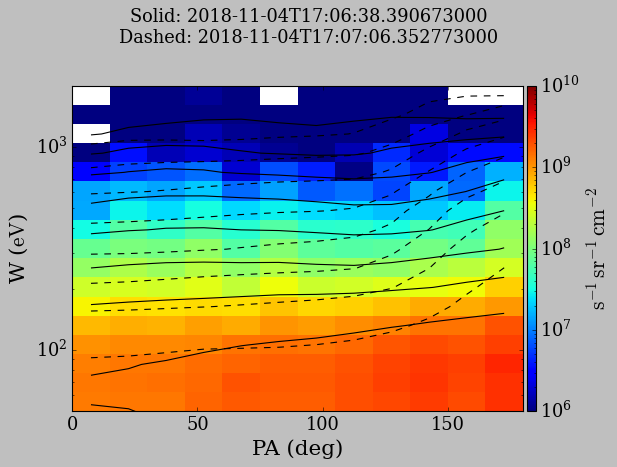

In [5]:
fig, ax = mu.plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle(f"Solid: {t_spe[i2]}\nDashed: {t_spe[i3]}")

cax = mu.add_colorbar(ax)
ax.contour(P_spe[i3, :].value, W_spe[i3, :].value, convolve(F_spe[i3, :, :].T.value, kernel, **cvkw), linestyles="--", **ckw)
ax.contour(P_spe[i2, :].value, W_spe[i2, :].value, convolve(F_spe[i2, :, :].T.value, kernel, **cvkw), linestyles="-", **ckw)
im = ax.pcolormesh(P_spe[i2, :].value, W_spe[i2, :].value, F_spe[i2, :, :].T.value, **kw)
cb = fig.colorbar(im, cax=cax)
cb.set_label(f"{F_spe.unit:latex_inline}")

ax.set_ylabel(f"W ({W_spe.unit:latex_inline})")
ax.locator_params(axis="x", nbins=5)
ax.set_yscale("log")
ax.set_xlim(0, 180)
ax.set_ylim(50, 2e3)
ax.set_xlabel("PA (deg)")

fig.tight_layout()
mu.plt.show()

15-Aug-23 18:45:04: /tmp/ipykernel_14381/677000418.py:39: RuntimeWarning: divide by zero encountered in log10
  Fg = np.log10(F.value).ravel()

15-Aug-23 18:45:05: /tmp/ipykernel_14381/677000418.py:76: UserWarning: Log scale: values of z <= 0 have been masked
  axes[0].contour(Pg.value, Wg.value, F.value, linestyles="-", **ckw)



nc_f=75.63 1 / cm3; Vthc_f=3.20 1000 km / s
nh_f=96.46 1 / cm3; Vthh_f=2.56 1000 km / s; kh_f=4.31
ns_f=5.35 1 / cm3; Vths_para_f=4.45 1000 km / s; Vths_perp_f=3.32 1000 km / s; Vs_drift_f=-4.13 1000 km / s; ks_f=9.13


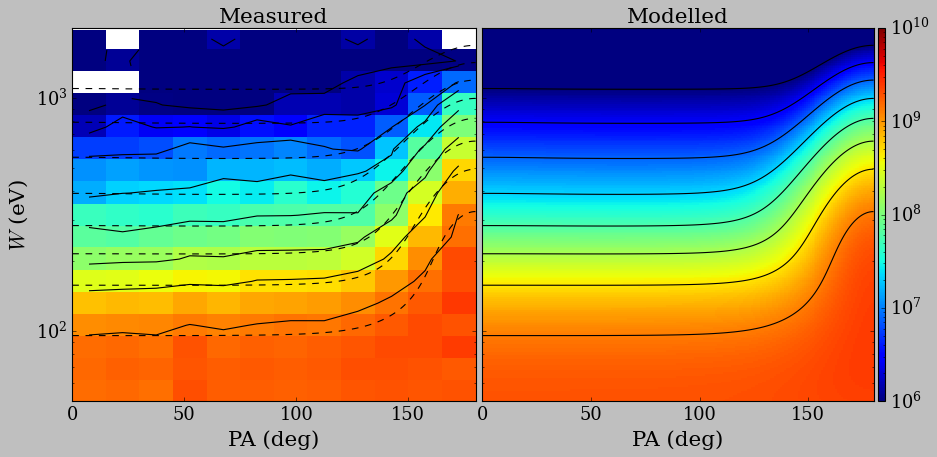

In [6]:
from wimh.utils.distribution_function import f_maxwellian, f_kappa


def f_model(V_para, V_perp, nc, Vthc, nh, Vthh, kh, ns, Vths_para, Vths_perp, Vs_drift, ks):
    return (f_maxwellian(V_para, V_perp, n=nc, Vth_para=Vthc, Vth_perp=Vthc)
            + f_kappa(V_para, V_perp, n=nh, Vth_para=Vthh, Vth_perp=Vthh, kappa=kh)
            + f_kappa(V_para, V_perp, n=ns, Vth_para=Vths_para, Vth_perp=Vths_perp, V_drift=Vs_drift, kappa=ks))


def fit_func(x, nc, Vthc, nh, Vthh, kh, ns, Vths_para, Vths_perp, Vs_drift, ks):
    P, W = x
    V = np.sqrt(2 * W * u.eV / c.si.m_e).to(u.Unit("1000 km/s"))
    V_para = V * np.cos(P * u.deg)
    V_perp = V * np.sin(P * u.deg)
    nc *= u.Unit("cm-3")
    nh *= u.Unit("cm-3")
    ns *= u.Unit("cm-3")
    Vthc *= u.Unit("1000 km/s")
    Vthh *= u.Unit("1000 km/s")
    Vths_para *= u.Unit("1000 km/s")
    Vths_perp *= u.Unit("1000 km/s")
    Vs_drift *= u.Unit("1000 km/s")
    _f_model = f_model(V_para, V_perp, nc, Vthc, nh, Vthh, kh, ns, Vths_para, Vths_perp, Vs_drift, ks)
    return np.log10((V**4 / 2 * _f_model).to(u.Unit("cm-2 s-1")).value)


# ---- Fit
P = P_spe[i3, :]
W = W_spe[i3, :]
F = F_spe[i3, :, :]
good = W >= (50 * u.eV)
Pg, Wg = np.meshgrid(P, W[good], indexing="ij")
F = F[:, good]

xdata = np.vstack((Pg.ravel().value, Wg.ravel().value))
guess = (100, 3.5, 30, 3.0, 10, 1, 4.0, 4.0, -4.5, 10)
bounds = (np.array([0, 0, 0, 0, 1.5, 0, 0, 0, -np.inf, 1.5]),
          np.array([np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf,]))
Fg = np.log10(F.value).ravel()
xdata = np.vstack((Pg.ravel().value[np.isfinite(Fg)], Wg.ravel().value[np.isfinite(Fg)]))
Fg = Fg[np.isfinite(Fg)]
popt, pcov = curve_fit(fit_func, xdata, Fg, p0=guess, bounds=bounds)
nc_f = popt[0] * u.Unit("cm-3")
Vthc_f = popt[1] * u.Unit("1000 km/s")
nh_f = popt[2] * u.Unit("cm-3")
Vthh_f = popt[3] * u.Unit("1000 km/s")
kh_f = popt[4]
ns_f = popt[5] * u.Unit("cm-3")
Vths_para_f = popt[6] * u.Unit("1000 km/s")
Vths_perp_f = popt[7] * u.Unit("1000 km/s")
Vs_drift_f = popt[8] * u.Unit("1000 km/s")
ks_f = popt[9]
print(f"{nc_f=:.2f}; {Vthc_f=:.2f}")
print(f"{nh_f=:.2f}; {Vthh_f=:.2f}; {kh_f=:.2f}")
print(f"{ns_f=:.2f}; {Vths_para_f=:.2f}; {Vths_perp_f=:.2f}; {Vs_drift_f=:.2f}; {ks_f=:.2f}")

P_arr = np.linspace(0, 180, 200) * u.deg
W_arr = np.logspace(np.log10(50), np.log10(2e3), 200) * u.eV
PP, WW = np.meshgrid(P_arr, W_arr, indexing="ij")
VV = np.sqrt(2 * WW / c.si.m_e).to(u.km / u.s)
V_para = VV * np.cos(PP)
V_perp = VV * np.sin(PP)
_f_model = f_model(V_para, V_perp, nc_f, Vthc_f, nh_f, Vthh_f, kh_f, ns_f, Vths_para_f, Vths_perp_f, Vs_drift_f, ks_f)
F_model = (VV**4 / 2 * _f_model).to(u.Unit("cm-2 s-1"))

fig, axes = mu.plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ckw = dict(
    norm=mu.mplc.LogNorm(),
    levels=np.logspace(6, 10, 10),
    zorder=999,
    linewidths=1,
    colors="k",
)

cax = mu.add_colorbar(axes[1])
axes[0].contour(Pg.value, Wg.value, F.value, linestyles="-", **ckw)
axes[0].contour(PP.value, WW.value, F_model.value, linestyles="--", **ckw)
axes[1].contour(PP.value, WW.value, F_model.value, linestyles="-", **ckw)
im = axes[0].pcolormesh(
    Pg.value, Wg.value, F.value, norm=mu.mplc.LogNorm(1e6, 1e10), cmap="jet"
)
im = axes[1].pcolormesh(
    PP.value,
    WW.value,
    F_model.value,
    norm=mu.mplc.LogNorm(1e6, 1e10),
    cmap="jet",
)
fig.colorbar(im, cax=cax)

axes[0].set_ylabel(f"$W$ (eV)")
axes[0].set_title("Measured")
axes[1].set_title("Modelled")
for i, ax in enumerate(axes):
    ax.set_yscale("log")
    ax.set_ylim(50, 2e3)
    ax.set_xlim(0, 180)
    ax.set_xlabel(f"PA (deg)")
    ax.locator_params(axis="x", nbins=5)

fig.tight_layout(w_pad=0.05)

mu.plt.show()